In [ ]:
%pip install scikit-learn

In [ ]:
%pip install pandas

In [ ]:
%pip install matplotlib


In [2]:
from metrics import evaluate_classification
from plots import plot_decision_boundary, plot_data

from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
class NeuralNet:
    def __init__(self, hidden_layers_sizes=[10, 100], normalize=True, learning_rate=0.01, num_iter=30000, reg_lambda=0, activation='sigmoid', early_stop=False):
        self.hidden_layers_sizes = hidden_layers_sizes
        self.normalize = normalize
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.reg_lambda = reg_lambda
        self.activation = activation
        self.early_stop = early_stop
        self.cost_history = []
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def __tanh(self, Z):
        return np.tanh(Z)

    def __relu(self, Z):
        return np.maximum(0, Z)

    def __initialize_parameters(self, n_x, n_1):
        n_h = len(self.hidden_layers_sizes)
        sizes = [n_x] + self.hidden_layers_sizes + [1]
        self.params = {}
        for i in range(1, n_h+2):
            self.params[f"W{i}"] = np.random.randn(sizes[i], sizes[i - 1]) * 0.01
            self.params[f"b{i}"] = np.zeros((sizes[i], 1))
    
    def __forward_propagation(self, X):
        cache = {"A0": X}
        n_h = len(self.hidden_layers_sizes)

        for i in range(1, n_h+2):
            W = self.params[f"W{i}"]
            b = self.params[f"b{i}"]
            A_prev = cache[f"A{i-1}"]
            Z = np.dot(W, A_prev) + b

            if self.activation == 'sigmoid':
                A = self.__sigmoid(Z)
            elif self.activation == 'tanh':
                A = self.__tanh(Z)
            elif self.activation == 'relu':
                A = self.__relu(Z)

            cache[f"Z{i}"] = Z
            cache[f"A{i}"] = A

        return A, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)

        for i in range(1, len(self.hidden_layers_sizes)+2):
            W = self.params[f"W{i}"]
            J += self.reg_lambda / 2 * m * np.sum(W * W)
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        grads = {}
        n_h = len(self.hidden_layers_sizes)
        dZ = cache[f"A{n_h+1}"] - Y
        

        grads[f"dW{n_h+1}"] = np.dot(dZ, cache[f"A{n_h}"].T) / m
        self.params[f"W{n_h+1}"] = (1 - self.learning_rate * self.reg_lambda / m) * self.params[f"W{n_h+1}"] - self.learning_rate * grads[f"dW{n_h+1}"]

        grads[f"db{n_h+1}"] = np.sum(dZ, axis=1, keepdims=True) / m
        self.params[f"b{n_h+1}"] = self.params[f"b{n_h+1}"] - self.learning_rate * grads[f"db{n_h+1}"] 

        for i in range(n_h, 0, -1):
            W_next = self.params[f"W{i+1}"]
            dZ_next = dZ
            A = cache[f"A{i}"]

            if self.activation == 'sigmoid':
                dZ = np.dot(W_next.T, dZ_next) * A * (1 - A)
            elif self.activation == 'tanh':
                dZ = np.dot(W_next.T, dZ_next) * (1 - np.power(A, 2))
            elif self.activation == 'relu':
                dZ = np.dot(W_next.T, dZ_next) * (A > 0)

            grads[f"dW{i}"] = np.dot(dZ, cache[f"A{i-1}"].T) / m
            self.params[f"W{i}"] = (1 - self.learning_rate * self.reg_lambda / m) * self.params[f"W{i}"] - self.learning_rate * grads[f"dW{i}"]

            grads[f"db{i}"] = np.sum(dZ, axis=1, keepdims=True) / m
            self.params[f"b{i}"] = self.params[f"b{i}"] - self.learning_rate * grads[f"db{i}"] 
        return grads
    
    def __update_parameters(self, grads):
        n_h = len(self.hidden_layers_sizes)
        for i in range(1, n_h+2):
            self.params[f"W{i}"] -= self.learning_rate * grads[f"dW{i}"]
            self.params[f"b{i}"] -= self.learning_rate * grads[f"db{i}"]

    def fit(self, X_vert, Y_vert, print_cost = True):
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)

        costs = []
        
        n_x, n_1 = X.shape[0], self.hidden_layers_sizes[0]
        self.__initialize_parameters(n_x, n_1)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            cost = self.compute_cost(A, Y)
            grads = self.__backward_propagation(X, Y, cache)
            self.__update_parameters(grads)
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

            if i > 100 and np.mean(costs[-10:]) >= np.mean(costs[-20:-10]):
                print(f"Early stopping after iteration {i}.")
                break
        
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((1 - probs.T, probs.T))

    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 1]
        return (positive_probs >= 0.5).astype(int) 

# Симульовані дані 1

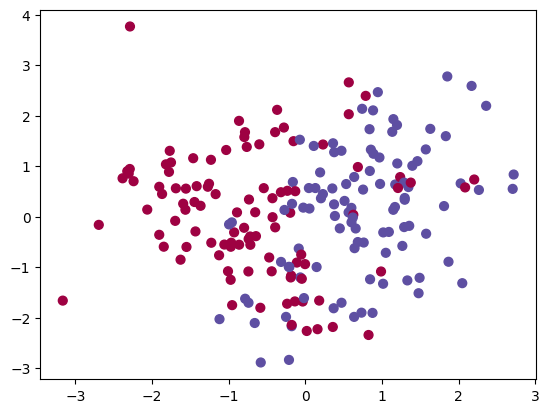

0-th iteration: 0.6937916680406782


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1000-th iteration: 0.6937422624045149
2000-th iteration: 0.6937450534018903
3000-th iteration: 0.6937522394677398
4000-th iteration: 0.6937665732822016
5000-th iteration: 0.6937938409292245
6000-th iteration: 0.6938463660162333
7000-th iteration: 0.6939528470985855
8000-th iteration: 0.6941918809951583
9000-th iteration: 0.6948442392375208
10000-th iteration: 0.6973799707607716
Early stopping after iteration 10000.


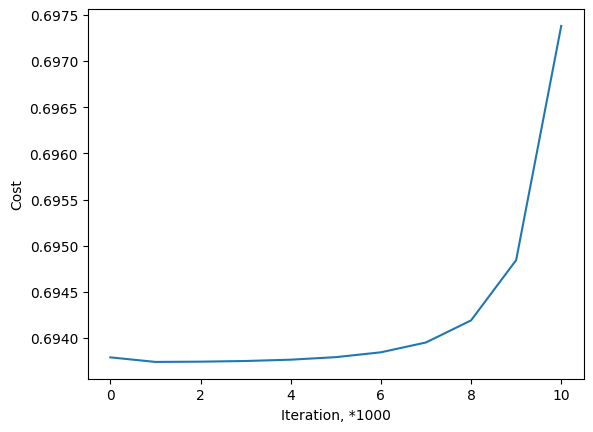

Accuracy: 
0.45
Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.45      1.00      0.62        18

    accuracy                           0.45        40
   macro avg       0.23      0.50      0.31        40
weighted avg       0.20      0.45      0.28        40

Confusion: 
   0   1
0  0  22
1  0  18


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: U

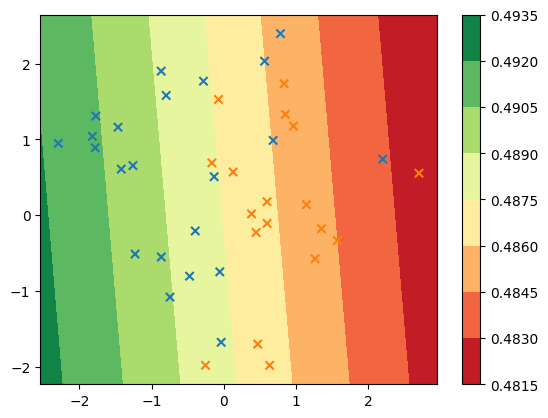

In [4]:
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)
plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet(early_stop=True, learning_rate=0.05, reg_lambda=0.0001, num_iter=25000, activation='sigmoid')
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Симульовані дані 2

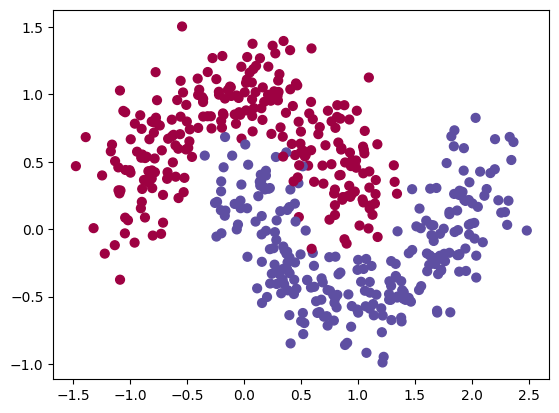

0-th iteration: 0.6958518929210418


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1000-th iteration: 2.44339779322133
2000-th iteration: 2.411604092496824
3000-th iteration: 2.525187842405686
4000-th iteration: 2.7113065689013367
5000-th iteration: 3.048105454355434
6000-th iteration: 3.734667997163598
7000-th iteration: 6.527560578642632
8000-th iteration: 7.355608512989152
9000-th iteration: 8.140190239806628
10000-th iteration: 9.000565482547938
Early stopping after iteration 10000.


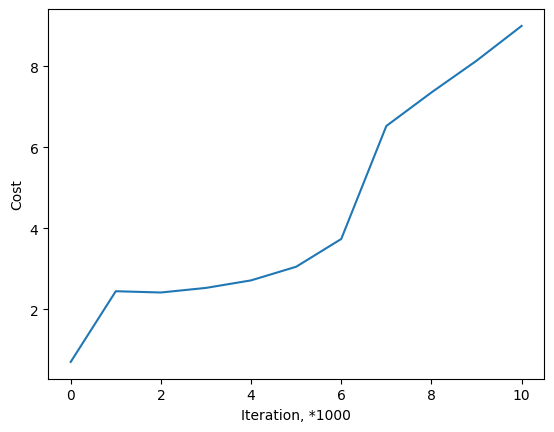

Accuracy: 
0.98
Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        43
           1       1.00      0.96      0.98        57

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

Confusion: 
    0   1
0  43   0
1   2  55


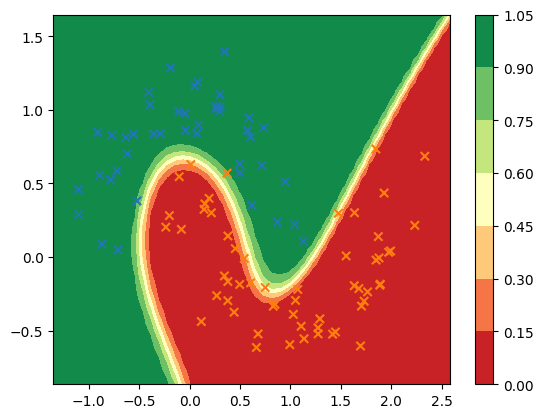

In [5]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet(learning_rate = 0.5, reg_lambda=0.0001)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

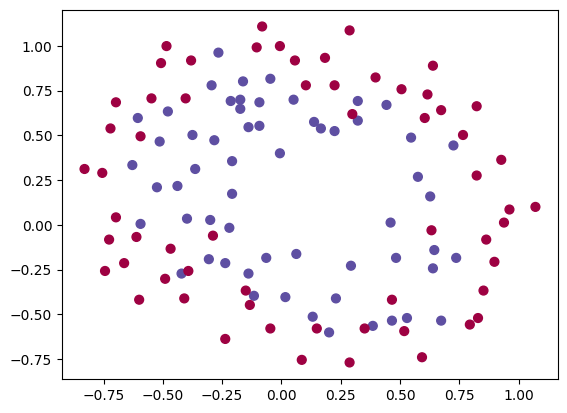

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column].values

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

0-th iteration: 0.6929090444127824
1000-th iteration: 0.6519163454106475


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2000-th iteration: 0.3852895850176333
3000-th iteration: 0.349800326483585
4000-th iteration: 0.31174000738561747
5000-th iteration: 0.2984620792834721
6000-th iteration: 0.28739054274768167
7000-th iteration: 0.2743348906839212
8000-th iteration: 0.2661074304780029
9000-th iteration: 0.2603639401192406
10000-th iteration: 0.2549643682950526
11000-th iteration: 0.24922346466027978
12000-th iteration: 0.24157153854696325
13000-th iteration: 0.2295782532538764
14000-th iteration: 0.21480186847436217
15000-th iteration: 0.20134716560393312
16000-th iteration: 0.18983042241254877
17000-th iteration: 0.1795651256938875
18000-th iteration: 0.1705706038863662
19000-th iteration: 0.16315367256856245


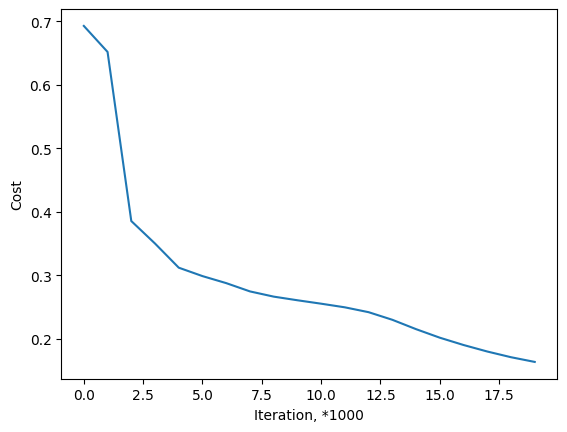

Accuracy: 
0.7916666666666666
Report: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24

Confusion: 
    0  1
0  10  2
1   3  9


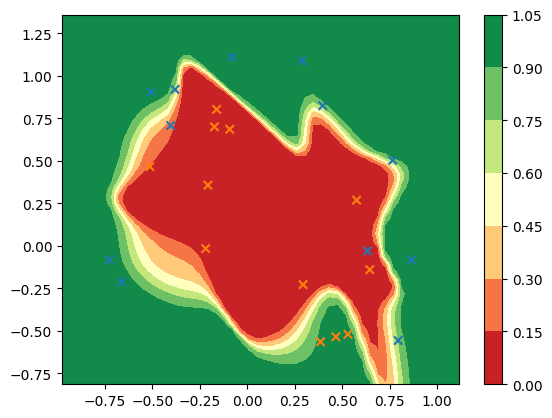

In [7]:
nn = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 20000, hidden_layers_sizes=[20])
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

In [9]:
print(nn.params)

{'W1': array([[  3.24470182,  -4.22569283],
       [ -4.06170992, -11.58659741],
       [  2.45715092,   0.37544155],
       [ -0.63951072,  -4.72743696],
       [ -2.88750001,  -5.00328122],
       [  2.21953065,   0.35524044],
       [  1.94554621,   0.34209619],
       [-14.31388919,  -3.3957451 ],
       [  1.94844036,   0.34272825],
       [  2.38461225,   0.36738472],
       [ -1.37397158,  -0.14990172],
       [ 14.76700588,   2.78192544],
       [  1.77887356, -11.62625638],
       [  1.67705143,   0.32801691],
       [  6.17230493,  -0.84525648],
       [  9.47021302,   8.09923915],
       [  2.05542183,   0.34735637],
       [  2.30964301,   0.36058217],
       [ -4.14982608,  -0.07025316],
       [  2.18704113,   0.35310288]]), 'b1': array([[-4.65894961],
       [-4.08085258],
       [-2.7722317 ],
       [ 6.56210536],
       [-8.3172193 ],
       [-2.46454764],
       [-2.09635586],
       [10.88984768],
       [-2.10011975],
       [-2.67911598],
       [-1.30625469],
   

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

Accuracy: 
0.75
Report: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.75      0.75      0.75        12

    accuracy                           0.75        24
   macro avg       0.75      0.75      0.75        24
weighted avg       0.75      0.75      0.75        24

Confusion: 
   0  1
0  9  3
1  3  9


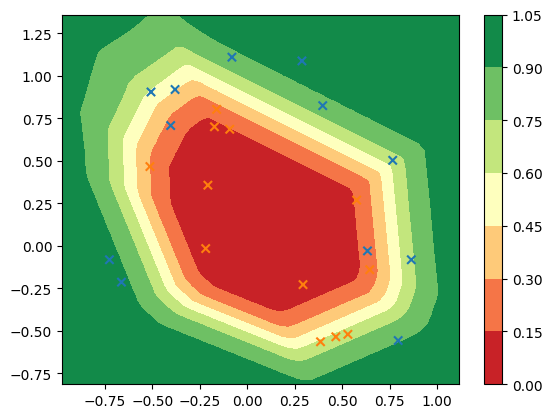

In [10]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(clf, X_test, y_test)
plt.show()

In [11]:
clf.n_iter_

1388